In [1]:
import cudf
import matplotlib.pyplot as plt
print(cudf.__version__)
import numpy as np
import cupy as cp
import pandas as pd
from tqdm import tqdm

23.04.01


In [2]:
chunk_size = 100000

chunks = []

# read the CSV file in chunks
for chunk in pd.read_csv('/workspaces/wiggle-face/keypoints_clean_yt_dataset.csv', chunksize=chunk_size):
    # pandas DataFrame chunk to cuDF DataFrame
    cudf_chunk = cudf.DataFrame.from_pandas(chunk)
    chunks.append(cudf_chunk)

# concatenate
df = cudf.concat(chunks, ignore_index=True)

print(df.head())

   infant_id        date  cam  frame_id  \
0          3  2021_07_21    3         1   
1          3  2021_07_21    3         1   
2          3  2021_07_21    3         1   
3          3  2021_07_21    3         1   
4          3  2021_07_21    3         1   

                                   keypoint  keypoint_score face_part  \
0    (1014.84423828125, 233.82086181640625)        0.599657      Chin   
1   (1015.7692260742188, 246.3082275390625)        0.652621      Chin   
2   (1016.6942138671875, 256.0206298828125)        0.652451      Chin   
3  (1018.0817260742188, 266.65802001953125)        0.698503      Chin   
4     (1019.9317016601562, 277.29541015625)        0.665730      Chin   

   keypoint_index                        processed_keypoint  
0               1    (1014.84423828125, 233.82086181640625)  
1               2  (1015.3067321777344, 240.06454467773438)  
2               3  (1015.7692260742188, 245.38323974609375)  
3               4   (1016.848388671875, 256.3289591471

In [3]:
# split the keypoint column into 2 columns for the x and y coordinates
df[['x_coordinate', 'y_coordinate']] = df['keypoint'].str.extract(r'\(([^,]+), ([^,]+)\)').astype(np.float64)
df = df.drop(columns=['keypoint'])
df = df.sort_values(by=['infant_id', 'frame_id', 'keypoint_index']).reset_index(drop=True)
    
print(df.head(319))

     infant_id        date  cam  frame_id  keypoint_score    face_part  \
0            3  2021_07_21    3         1        0.599657         Chin   
1            3  2021_07_21    3         1        0.652621         Chin   
2            3  2021_07_21    3         1        0.652451         Chin   
3            3  2021_07_21    3         1        0.698503         Chin   
4            3  2021_07_21    3         1        0.665730         Chin   
..         ...         ...  ...       ...             ...          ...   
314          3  2021_07_21    3         3        0.910907        Mouth   
315          3  2021_07_21    3         3        0.900475        Mouth   
316          3  2021_07_21    3         3        0.960341  Right_Pupil   
317          3  2021_07_21    3         3        0.964819   Left_Pupil   
318          3  2021_07_21    3         4        0.739435         Chin   

     keypoint_index                        processed_keypoint  x_coordinate  \
0                 1    (1014.844

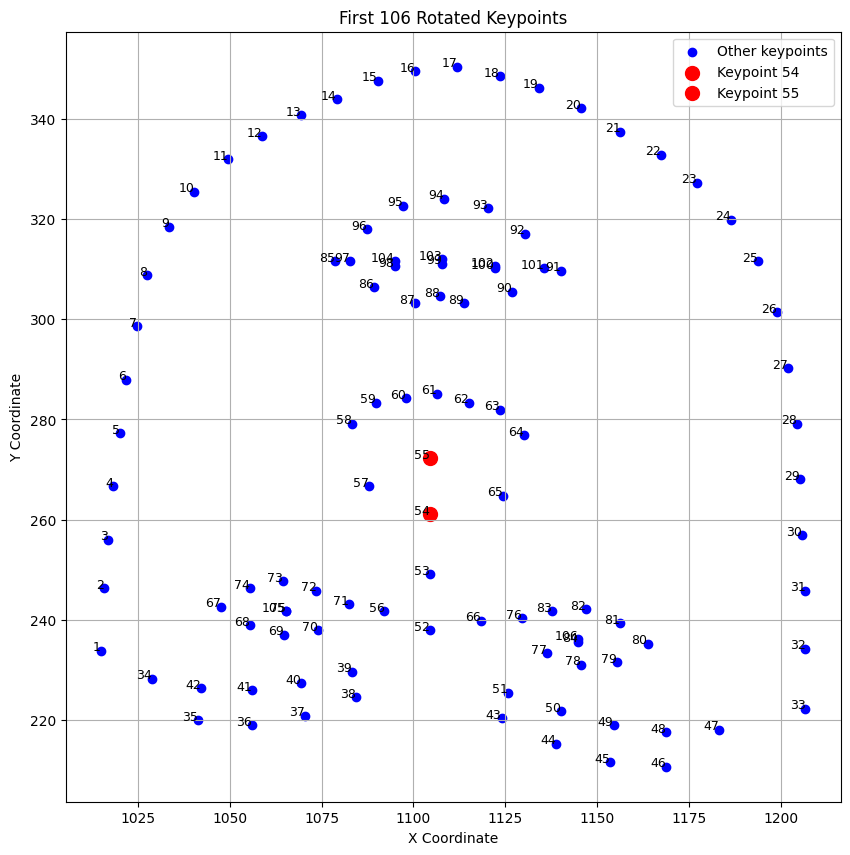

In [4]:
# figure
plt.figure(figsize=(10, 10))
x_coords = df['x_coordinate'][:106].values
y_coords = df['y_coordinate'][:106].values

x_coords = np.array(x_coords.get())
y_coords = np.array(y_coords.get())

plt.scatter(x_coords, y_coords, c='blue', marker='o', label='Other keypoints')

kp_54_index = 53 
kp_55_index = 54

plt.scatter(x_coords[kp_54_index], y_coords[kp_54_index], c='red', marker='o', label='Keypoint 54', s=100)
plt.scatter(x_coords[kp_55_index], y_coords[kp_55_index], c='red', marker='o', label='Keypoint 55', s=100)

for i in range(106):
    plt.text(x_coords[i], y_coords[i], str(i+1), fontsize=9, ha='right')
plt.title('First 106 Rotated Keypoints')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.legend()
plt.show()

In [139]:
def move_and_rotate_keypoints_updated(df):
    def get_rotation_matrix(angle):
        return np.array([
            [np.cos(angle), -np.sin(angle)],
            [np.sin(angle), np.cos(angle)]
        ])

    def rotate_points(points, angle):
        rotation_matrix = get_rotation_matrix(angle)
        return np.dot(points, rotation_matrix.T)

    def normalize_points(points):
        min_vals = points.min(axis=0)
        max_vals = points.max(axis=0)
        scale = max(max_vals - min_vals)
        normalized_points = 2 * ((points - min_vals) / scale) - 1
        return normalized_points

    def sum_abs_x(angle):
        rotated = rotate_points(translated_coords_np, angle)
        return np.sum(np.abs(rotated[:, 0]))
        
    result = []

    # keypoint indexes to be aligned
    align_keypoints = [52, 53, 54, 55, 17, 88, 94]

    grouped = df.groupby(['infant_id', 'frame_id'])
    
    for (infant_id, frame_id), group in tqdm(grouped, desc="Processing frames"):
        kp_54 = cp.array(group[group['keypoint_index'] == 55][['x_coordinate', 'y_coordinate']].values[0])
        
        # coordinates of the keypoints to be aligned
        keypoints_to_align = cp.array(group[group['keypoint_index'].isin(align_keypoints)][['x_coordinate', 'y_coordinate']].values)
        translated_coords = keypoints_to_align - kp_54
        translated_coords_np = translated_coords.get()
        
        # optimal angle to minimize the sum of absolute x-coordinates
        angles = np.linspace(-np.pi, np.pi, 360)
        optimal_angle = angles[np.argmin([sum_abs_x(a) for a in angles])]
        
        # translate all keypoints relative to kp_54
        all_translated_coords = cp.array(group[['x_coordinate', 'y_coordinate']].values) - kp_54
    
        all_translated_coords_np = all_translated_coords.get()
        rotated_coords = rotate_points(all_translated_coords_np, optimal_angle)
        normalized_coords = normalize_points(rotated_coords)
 
        kp_54_index = group['keypoint_index'].values == 55
        normalized_coords -= normalized_coords[kp_54_index.get()].reshape(1, -1)
        
        kp_52_y = normalized_coords[group['keypoint_index'].values.get() == 52][0, 1]
        kp_17_y = normalized_coords[group['keypoint_index'].values.get() == 17][0, 1]
        
        if kp_52_y < 0 or kp_17_y > 0:
            normalized_coords = rotate_points(normalized_coords, np.pi)

        transformed_group = group.copy()
        transformed_group[['x_coordinate', 'y_coordinate']] = normalized_coords
        
        result.append(transformed_group.to_pandas())
    
    return pd.concat(result).reset_index(drop=True)

transformed_df = move_and_rotate_keypoints_updated(cudf.DataFrame(df))
print(transformed_df)

Processing frames: 35516it [05:05, 116.35it/s]


         infant_id        date  cam  frame_id  keypoint_score    face_part  \
0                3  2021_07_21    3         1        0.599657         Chin   
1                3  2021_07_21    3         1        0.652621         Chin   
2                3  2021_07_21    3         1        0.652451         Chin   
3                3  2021_07_21    3         1        0.698503         Chin   
4                3  2021_07_21    3         1        0.665730         Chin   
...            ...         ...  ...       ...             ...          ...   
3764691         48  2022_09_15    3      3585        0.896365        Mouth   
3764692         48  2022_09_15    3      3585        0.871878        Mouth   
3764693         48  2022_09_15    3      3585        0.857041        Mouth   
3764694         48  2022_09_15    3      3585        0.870727  Right_Pupil   
3764695         48  2022_09_15    3      3585        0.949768   Left_Pupil   

         keypoint_index  x_coordinate  y_coordinate  
0        

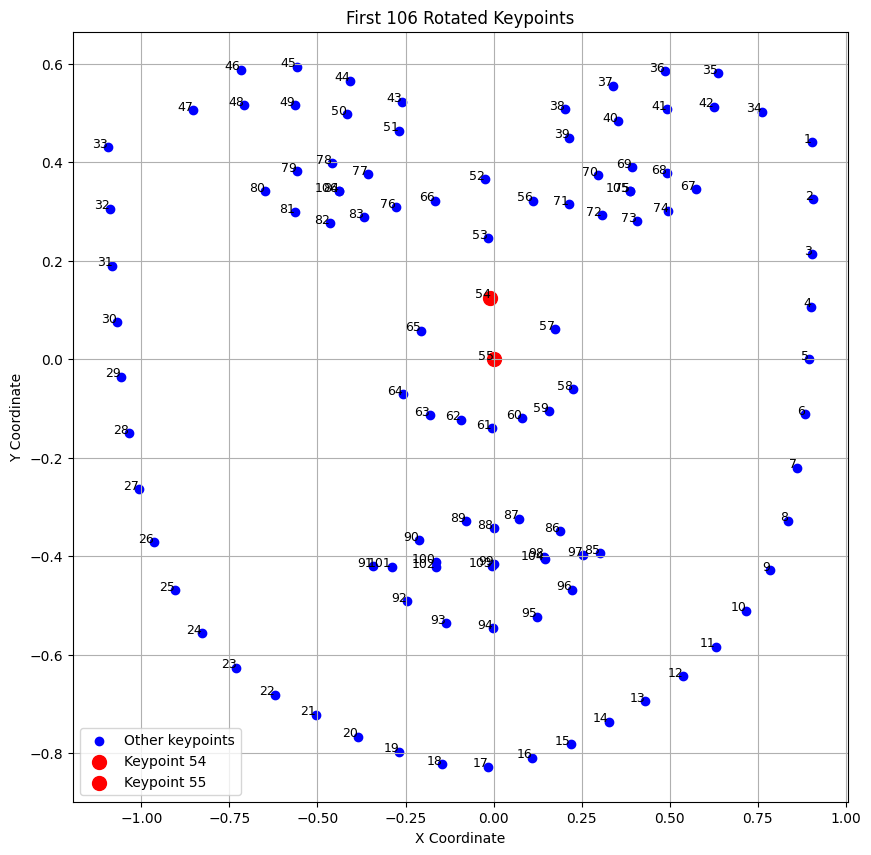

In [140]:
# figure
plt.figure(figsize=(10, 10))

x_coords = transformed_df['x_coordinate'][318:424].values
y_coords = transformed_df['y_coordinate'][318:424].values

x_coords = np.array(x_coords)
y_coords = np.array(y_coords)

plt.scatter(x_coords, y_coords, c='blue', marker='o', label='Other keypoints')

kp_54_index = 53  
kp_55_index = 54  

plt.scatter(x_coords[kp_54_index], y_coords[kp_54_index], c='red', marker='o', label='Keypoint 54', s=100)
plt.scatter(x_coords[kp_55_index], y_coords[kp_55_index], c='red', marker='o', label='Keypoint 55', s=100)

for i in range(106):
    plt.text(x_coords[i], y_coords[i], str(i+1), fontsize=9, ha='right')

plt.title('First 106 Rotated Keypoints')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
df.drop(['processed_keypoint'], axis=1, inplace=True)
transformed_df.drop(['processed_keypoint'], axis=1, inplace=True)


In [142]:
df.head(107)

,infant_id,date,cam,frame_id,keypoint_score,face_part,keypoint_index,x_coordinate,y_coordinate
0,3,2021_07_21,3,1,0.599657,Chin,1,1014.844238,233.820862
1,3,2021_07_21,3,1,0.652621,Chin,2,1015.769226,246.308228
2,3,2021_07_21,3,1,0.652451,Chin,3,1016.694214,256.020630
3,3,2021_07_21,3,1,0.698503,Chin,4,1018.081726,266.658020
4,3,2021_07_21,3,1,0.665730,Chin,5,1019.931702,277.295410
...,...,...,...,...,...,...,...,...,...
102,3,2021_07_21,3,1,0.867496,Mouth,103,1107.805786,311.982544
103,3,2021_07_21,3,1,0.787867,Mouth,104,1094.855957,311.520020
104,3,2021_07_21,3,1,0.962338,Right_Pupil,105,1065.256226,241.683273
105,3,2021_07_21,3,1,0.973562,Left_Pupil,106,1144.805420,236.133331


In [143]:
transformed_df.head(107)

,infant_id,date,cam,frame_id,keypoint_score,face_part,keypoint_index,x_coordinate,y_coordinate
0,3,2021_07_21,3,1,0.599657,Chin,1,0.898815,0.471397
1,3,2021_07_21,3,1,0.652621,Chin,2,0.899442,0.341176
2,3,2021_07_21,3,1,0.652451,Chin,3,0.897799,0.239725
3,3,2021_07_21,3,1,0.698503,Chin,4,0.892118,0.128305
4,3,2021_07_21,3,1,0.665730,Chin,5,0.881642,0.016507
...,...,...,...,...,...,...,...,...,...
102,3,2021_07_21,3,1,0.867496,Mouth,103,-0.001020,-0.415016
103,3,2021_07_21,3,1,0.787867,Mouth,104,0.132861,-0.399625
104,3,2021_07_21,3,1,0.962338,Right_Pupil,105,0.382596,0.348634
105,3,2021_07_21,3,1,0.973562,Left_Pupil,106,-0.446679,0.341084


In [144]:
df = transformed_df

In [156]:
# new dataframe with unique infant_id and frame_id combinations
face_feature_df = df[['infant_id', 'frame_id']].drop_duplicates().reset_index(drop=True)

# keypoint indices for the left and right eyebrows
left_brow_indices = cp.array(list(range(34, 43)))
right_brow_indices = cp.array(list(range(43, 52)))
lip_pairs = [(100, 102), (99, 103), (98, 104)]
right_eye_pairs = [(79, 81), (78, 82), (77, 83)]
left_eye_pairs = [(70, 72), (69, 73), (68, 74)]

# dataframe columns to CuPy arrays for keypoints
infant_ids = cp.array(df['infant_id'].values)
frame_ids = cp.array(df['frame_id'].values)
keypoint_indices = cp.array(df['keypoint_index'].values)
y_coords = cp.array(df['y_coordinate'].values)

# func to calculate the mean y-coordinate for specified keypoints
def calculate_mean_y_coord_cp(infant_ids, frame_ids, keypoint_indices, y_coords, infant_id, frame_id, brow_indices):
    mask = (infant_ids == infant_id) & (frame_ids == frame_id) & (cp.isin(keypoint_indices, brow_indices))
    return y_coords[mask].mean()

# func to calculate the mean distance between specified keypoints
def calculate_mean_distance_cp(infant_ids, frame_ids, keypoint_indices, y_coords, infant_id, frame_id, points):
    distances = []
    for p1, p2 in points:
        mask1 = (infant_ids == infant_id) & (frame_ids == frame_id) & (keypoint_indices == p1)
        mask2 = (infant_ids == infant_id) & (frame_ids == frame_id) & (keypoint_indices == p2)
        kp1 = y_coords[mask1]
        kp2 = y_coords[mask2]
        if kp1.size > 0 and kp2.size > 0:
            distance = cp.abs(kp1 - kp2)
            distances.append(distance)
    return cp.mean(cp.array(distances)) if distances else cp.nan

In [159]:
# calculate mean y-coordinates for the eyebrows with progress tracking
mean_y_coord_left_brow = []
mean_y_coord_right_brow = []

for index in tqdm(range(len(face_feature_df)), desc='Calculating mean y-coordinates for eyebrows'):
    infant_id = face_feature_df['infant_id'].iloc[index]
    frame_id = face_feature_df['frame_id'].iloc[index]
    
    mean_y_coord_left_brow.append(
        calculate_mean_y_coord_cp(infant_ids, frame_ids, keypoint_indices, y_coords, infant_id, frame_id, left_brow_indices).get()
    )
    mean_y_coord_right_brow.append(
        calculate_mean_y_coord_cp(infant_ids, frame_ids, keypoint_indices, y_coords, infant_id, frame_id, right_brow_indices).get()
    )

# add the results back to the dataframe
face_feature_df['mean_y_coord_left_brow'] = mean_y_coord_left_brow
face_feature_df['mean_y_coord_right_brow'] = mean_y_coord_right_brow

print(face_feature_df)

Calculating mean y-coordinates for eyebrows:   5%|▌         | 1917/35516 [03:48<1:06:41,  8.40it/s]

In [147]:
# calculate distances with progress tracking
right_eye_eyelid_distance = []
left_eye_eyelid_distance = []
lip_distance = []

# iterate over each row in the face_feature_df
for index in tqdm(range(len(face_feature_df)), desc='Calculating distances for keypoints'):
    infant_id = face_feature_df['infant_id'].iloc[index]
    frame_id = face_feature_df['frame_id'].iloc[index]
    
    right_eye_eyelid_distance.append(
        calculate_mean_distance_cp(infant_ids, frame_ids, keypoint_indices, y_coords, infant_id, frame_id, right_eye_pairs).get()
    )
    left_eye_eyelid_distance.append(
        calculate_mean_distance_cp(infant_ids, frame_ids, keypoint_indices, y_coords, infant_id, frame_id, left_eye_pairs).get()
    )
    lip_distance.append(
        calculate_mean_distance_cp(infant_ids, frame_ids, keypoint_indices, y_coords, infant_id, frame_id, lip_pairs).get()
    )

Calculating distances for keypoints: 100%|██████████| 35516/35516 [11:03<00:00, 53.49it/s]


In [148]:
# add the results back to the dataframe
face_feature_df['mean_y_coord_left_brow'] = mean_y_coord_left_brow
face_feature_df['mean_y_coord_right_brow'] = mean_y_coord_right_brow
face_feature_df['right_eye_eyelid_distance'] = right_eye_eyelid_distance
face_feature_df['left_eye_eyelid_distance'] = left_eye_eyelid_distance
face_feature_df['lip_distance'] = lip_distance

# determine if the eyes and mouth are closed based on the distances
threshold_eyes = 0.3
threshold_mouth =  0.2 
face_feature_df['right_eye_closed'] = face_feature_df['right_eye_eyelid_distance'] < threshold_eyes
face_feature_df['left_eye_closed'] = face_feature_df['left_eye_eyelid_distance'] < threshold_eyes
face_feature_df['mouth_closed'] = face_feature_df['lip_distance'] < threshold_mouth

print(face_feature_df)

       infant_id  frame_id mean_y_coord_left_brow mean_y_coord_right_brow  \
0              3         1      0.530070004925403      0.5263228196380215   
1              3         2     0.5201565350019064      0.5311752809262391   
2              3         3     0.5279863127764517      0.5279551486925027   
3              3         4     0.5210283932507637      0.5304055048971255   
4              3         5     0.5228643170074768      0.5245021053015894   
...          ...       ...                    ...                     ...   
35511         48      3581     0.4216791154046232     0.43711022263772586   
35512         48      3582     0.4114452845497509     0.43169796812968303   
35513         48      3583    0.41328494839147173      0.4328677778234649   
35514         48      3584     0.4296647318883249     0.44497222455891094   
35515         48      3585     0.4178139399885984     0.44272256848993213   

      right_eye_eyelid_distance left_eye_eyelid_distance  \
0            0.

In [39]:
# 43 - 47 upper right brow 
# 48 - 51 lower right brow
# 34 - 38 upper left brow 
# 39 - 42 lower left brow
# 67 - 71 upper left eyelid
# 72 - 74 lower left eyelid
# 76 - 80 upper right eyelid
# 81 - 83 lower right eyelid
# 85 - 91 upper outer lip
# 92 - 97 lower outer lip
# 98 - 101 upper inner lip
# 102 - 104 lower inner lip 

# function for curvatures
def calculate_curvature_cp(infant_ids, frame_ids, keypoint_indices, x_coords, y_coords, infant_id, frame_id, indices):
    mask = (infant_ids == infant_id) & (frame_ids == frame_id) & (cp.isin(keypoint_indices, indices))
    x_coords_filtered = x_coords[mask]
    y_coords_filtered = y_coords[mask]
    
    if len(x_coords_filtered) < 3 or len(y_coords_filtered) < 3:
        return cp.nan  # Need at least 3 points to calculate second derivative
    
    x_second_derivative = cp.gradient(cp.gradient(x_coords_filtered))
    y_second_derivative = cp.gradient(cp.gradient(y_coords_filtered))
    curvature = cp.mean(cp.sqrt(x_second_derivative**2 + y_second_derivative**2))
    return curvature

In [40]:
# keypoint indices for the specified face parts
upper_right_brow_indices = cp.array(list(range(43, 48)))
lower_right_brow_indices = cp.array(list(range(48, 52)))
upper_left_brow_indices = cp.array(list(range(34, 39)))
lower_left_brow_indices = cp.array(list(range(39, 43)))
upper_left_eyelid_indices = cp.array(list(range(67, 72)))
lower_left_eyelid_indices = cp.array(list(range(72, 75)))
upper_right_eyelid_indices = cp.array(list(range(76, 81)))
lower_right_eyelid_indices = cp.array(list(range(81, 84)))
upper_outer_lip_indices = cp.array(list(range(85, 92)))
lower_outer_lip_indices = cp.array(list(range(92, 98)))
upper_inner_lip_indices = cp.array(list(range(98, 102)))
lower_inner_lip_indices = cp.array(list(range(102, 105)))

# dataFrame columns to CuPy arrays for keypoints
infant_ids = cp.array(df['infant_id'].values)
frame_ids = cp.array(df['frame_id'].values)
keypoint_indices = cp.array(df['keypoint_index'].values)
x_coords = cp.array(df['x_coordinate'].values)
y_coords = cp.array(df['y_coordinate'].values)

# calculate curvatures for each specified face part
curvature_upper_right_brow = []
curvature_lower_right_brow = []
curvature_upper_left_brow = []
curvature_lower_left_brow = []
curvature_upper_left_eyelid = []
curvature_lower_left_eyelid = []
curvature_upper_right_eyelid = []
curvature_lower_right_eyelid = []
curvature_upper_outer_lip = []
curvature_lower_outer_lip = []
curvature_upper_inner_lip = []
curvature_lower_inner_lip = []

for index in tqdm(range(len(face_feature_df)), desc='Calculating curvatures for specified face parts'):
    infant_id = face_feature_df['infant_id'].iloc[index]
    frame_id = face_feature_df['frame_id'].iloc[index]
    
    curvature_upper_right_brow.append(
        calculate_curvature_cp(infant_ids, frame_ids, keypoint_indices, x_coords, y_coords, infant_id, frame_id, upper_right_brow_indices).get()
    )
    curvature_lower_right_brow.append(
        calculate_curvature_cp(infant_ids, frame_ids, keypoint_indices, x_coords, y_coords, infant_id, frame_id, lower_right_brow_indices).get()
    )
    curvature_upper_left_brow.append(
        calculate_curvature_cp(infant_ids, frame_ids, keypoint_indices, x_coords, y_coords, infant_id, frame_id, upper_left_brow_indices).get()
    )
    curvature_lower_left_brow.append(
        calculate_curvature_cp(infant_ids, frame_ids, keypoint_indices, x_coords, y_coords, infant_id, frame_id, lower_left_brow_indices).get()
    )
    curvature_upper_left_eyelid.append(
        calculate_curvature_cp(infant_ids, frame_ids, keypoint_indices, x_coords, y_coords, infant_id, frame_id, upper_left_eyelid_indices).get()
    )
    curvature_lower_left_eyelid.append(
        calculate_curvature_cp(infant_ids, frame_ids, keypoint_indices, x_coords, y_coords, infant_id, frame_id, lower_left_eyelid_indices).get()
    )
    curvature_upper_right_eyelid.append(
        calculate_curvature_cp(infant_ids, frame_ids, keypoint_indices, x_coords, y_coords, infant_id, frame_id, upper_right_eyelid_indices).get()
    )
    curvature_lower_right_eyelid.append(
        calculate_curvature_cp(infant_ids, frame_ids, keypoint_indices, x_coords, y_coords, infant_id, frame_id, lower_right_eyelid_indices).get()
    )
    curvature_upper_outer_lip.append(
        calculate_curvature_cp(infant_ids, frame_ids, keypoint_indices, x_coords, y_coords, infant_id, frame_id, upper_outer_lip_indices).get()
    )
    curvature_lower_outer_lip.append(
        calculate_curvature_cp(infant_ids, frame_ids, keypoint_indices, x_coords, y_coords, infant_id, frame_id, lower_outer_lip_indices).get()
    )
    curvature_upper_inner_lip.append(
        calculate_curvature_cp(infant_ids, frame_ids, keypoint_indices, x_coords, y_coords, infant_id, frame_id, upper_inner_lip_indices).get()
    )
    curvature_lower_inner_lip.append(
        calculate_curvature_cp(infant_ids, frame_ids, keypoint_indices, x_coords, y_coords, infant_id, frame_id, lower_inner_lip_indices).get()
    )

# add the curvature results back to the DataFrame
face_feature_df['curvature_upper_right_brow'] = curvature_upper_right_brow
face_feature_df['curvature_lower_right_brow'] = curvature_lower_right_brow
face_feature_df['curvature_upper_left_brow'] = curvature_upper_left_brow
face_feature_df['curvature_lower_left_brow'] = curvature_lower_left_brow
face_feature_df['curvature_upper_left_eyelid'] = curvature_upper_left_eyelid
face_feature_df['curvature_lower_left_eyelid'] = curvature_lower_left_eyelid
face_feature_df['curvature_upper_right_eyelid'] = curvature_upper_right_eyelid
face_feature_df['curvature_lower_right_eyelid'] = curvature_lower_right_eyelid
face_feature_df['curvature_upper_outer_lip'] = curvature_upper_outer_lip
face_feature_df['curvature_lower_outer_lip'] = curvature_lower_outer_lip
face_feature_df['curvature_upper_inner_lip'] = curvature_upper_inner_lip
face_feature_df['curvature_lower_inner_lip'] = curvature_lower_inner_lip

print(face_feature_df)

Calculating curvatures for specified face parts:   0%|          | 0/16255 [00:00<?, ?it/s]

Calculating curvatures for specified face parts: 100%|██████████| 16255/16255 [04:57<00:00, 54.58it/s]


       infant_id  frame_id  mean_y_coord_left_brow  mean_y_coord_right_brow  \
0              0      1052               26.348788                17.127944   
1              0      1053               26.198250                17.315864   
2              0      1054               26.715033                17.514939   
3              0      1055               26.413779                17.454999   
4              0      1056               26.339764                17.688944   
...          ...       ...                     ...                      ...   
16250        369      1918               33.724684                43.118234   
16251        369      1919               34.059471                43.134465   
16252        369      1920               34.205876                42.740573   
16253        369      1921               33.659804                42.891995   
16254        369      1922               32.333658                43.686978   

       right_eye_eyelid_distance  left_eye_eyelid_d

In [41]:
face_feature_df.head(10)

,infant_id,frame_id,mean_y_coord_left_brow,mean_y_coord_right_brow,right_eye_eyelid_distance,left_eye_eyelid_distance,lip_distance,right_eye_closed,left_eye_closed,mouth_closed,...,curvature_upper_left_brow,curvature_lower_left_brow,curvature_upper_left_eyelid,curvature_lower_left_eyelid,curvature_upper_right_eyelid,curvature_lower_right_eyelid,curvature_upper_outer_lip,curvature_lower_outer_lip,curvature_upper_inner_lip,curvature_lower_inner_lip
0,0,1052,26.348788,17.127944,5.550000,2.809016,4.694662,False,False,False,...,11.111430,2.824883,6.723070,2.855397,3.413346,2.344622,4.729379,2.265034,2.037664,4.843724
1,0,1053,26.198250,17.315864,5.347490,2.865359,4.537808,False,False,False,...,11.097507,2.847779,6.694395,2.885228,3.415470,2.350449,4.683896,2.245411,2.065836,4.851396
2,0,1054,26.715033,17.514939,5.421089,2.763375,4.664919,False,False,False,...,11.153215,2.903221,6.676370,2.843963,3.465242,2.312536,4.688894,2.235913,2.028987,4.858052
3,0,1055,26.413779,17.454999,5.608964,2.973785,4.289533,False,False,False,...,11.135602,2.879256,6.702055,2.731833,3.437882,2.269315,4.632252,2.204493,2.008019,4.823562
4,0,1056,26.339764,17.688944,5.519994,2.826190,4.047135,False,False,False,...,11.205075,2.884650,6.657463,2.736643,3.418091,2.242292,4.664352,2.241005,1.932819,4.877589
5,0,1057,26.800478,17.018553,5.905682,3.219371,4.432451,False,False,False,...,11.158769,2.907022,6.677693,2.676728,3.409422,2.239225,4.662863,2.186881,1.990597,4.864415
6,0,1058,26.210369,17.980474,5.361088,2.982106,3.972951,False,False,False,...,11.117427,2.891987,6.635313,2.642912,3.452225,2.225247,4.689694,2.151649,2.005203,4.797330
7,0,1059,26.673297,17.311865,5.654298,3.137977,4.471179,False,False,False,...,11.163941,2.894422,6.648241,2.661142,3.412086,2.287297,4.661045,2.171986,1.996862,4.836110
8,0,1060,27.130633,16.944667,5.895187,3.172633,4.645962,False,False,False,...,11.186713,2.959633,6.677680,2.628119,3.440977,2.198574,4.680449,2.183676,1.951376,4.746977
9,0,1061,27.564543,16.401343,6.202565,3.213017,5.028631,False,False,False,...,11.216672,2.972429,6.684235,2.742727,3.443310,2.211824,4.662198,2.213302,1.953490,4.717802


In [42]:
face_feature_df.to_csv('face_features_with_curvatures.csv', index=False)

In [75]:
# function to calculate displacement manually
def calculate_manual_displacement(group):
    group['shifted_x'] = group['x_coordinate'].shift(1)
    group['shifted_y'] = group['y_coordinate'].shift(1)

    group['interframe_x_displacement'] = group['x_coordinate'] -  group['shifted_x']
    group['interframe_y_displacement'] =  group['y_coordinate'] - group['shifted_y']

    group['interframe_x_displacement'] = group['interframe_x_displacement'].fillna(0)
    group['interframe_y_displacement'] = group['interframe_y_displacement'].fillna(0)
    
    return group

# displacement for all keypoints
df = df.groupby(['infant_id', 'keypoint_index']).apply(calculate_manual_displacement).reset_index(drop=True)
df = df.drop(columns = ['shifted_x','shifted_y'])
df.loc[df['frame_id'] == 0, ['interframe_x_displacement', 'interframe_y_displacement']] = 0.0

print(df.head(1320))

/opt/miniconda/envs/openmmlab/lib/python3.8/site-packages/cudf/core/groupby/groupby.py:1169: RuntimeWarning: GroupBy.apply() performance scales poorly with number of groups. Got 6890 groups. Some functions may perform better by passing engine='jit'
  warnings.warn(


      infant_id  frame_id  keypoint_score face_part  keypoint_index  \
0             0         0        0.577999      Chin               1   
1             0         1        0.514304      Chin               1   
2             0         2        0.493515      Chin               1   
3             0         3        0.466503      Chin               1   
4             0         4        0.473813      Chin               1   
...         ...       ...             ...       ...             ...   
1315          0      1315        0.711513      Chin               1   
1316          0      1316        0.703581      Chin               1   
1317          0      1317        0.721716      Chin               1   
1318          0      1318        0.754950      Chin               1   
1319          0         0        0.752206      Chin               2   

      x_coordinate  y_coordinate  interframe_x_displacement  \
0       351.601135    463.115295                   0.000000   
1       349.961029   

In [76]:
df.to_csv('displacements.csv', index=False)

In [77]:
mean_displacements = df.groupby(['infant_id', 'keypoint_index'])[['interframe_x_displacement', 'interframe_y_displacement']].mean().reset_index()
mean_displacements.rename(columns={
    'interframe_x_displacement': 'mean_x_displacement_keypoint',
    'interframe_y_displacement': 'mean_y_displacement_keypoint'
}, inplace=True)

# calculating the average confidence per keypoint per infant, based on keypoint_scores 
average_confidence = df.groupby(['infant_id', 'keypoint_index'])['keypoint_score'].mean().reset_index()
average_confidence.rename(columns={'keypoint_score': 'average_confidence_keypoint'}, inplace=True)
face_parts = df[['infant_id', 'keypoint_index', 'face_part']].drop_duplicates()

# merge all metrics
metrics_df = cudf.merge(mean_displacements, average_confidence, on=['infant_id', 'keypoint_index'])
metrics_df = cudf.merge(metrics_df, face_parts, on=['infant_id', 'keypoint_index'])

metrics_df = metrics_df.sort_values(by=['infant_id', 'keypoint_index'])
metrics_df = metrics_df.reset_index(drop=True)

print(metrics_df.head(107))

     infant_id  keypoint_index  mean_x_displacement_keypoint  \
0            0               1                     -0.108792   
1            0               2                     -0.104563   
2            0               3                     -0.100725   
3            0               4                     -0.097220   
4            0               5                     -0.093938   
..         ...             ...                           ...   
102          0             103                     -0.091342   
103          0             104                     -0.090394   
104          0             105                     -0.109413   
105          0             106                     -0.115715   
106          1               1                      0.000633   

     mean_y_displacement_keypoint  average_confidence_keypoint    face_part  
0                        0.010605                     0.495667         Chin  
1                        0.009601                     0.778484         Chin

In [78]:
metrics_df.to_csv('keypoints_metrics.csv', index=False)